# 1. What is your research question, hypothesis and assumptions? Is your result significant?


For this I am picking yellow taxi trip records(parquet) file for analysis. It includes information such as pickup time and dropoff time, trip distance and fares. I believe this can be useful for analyzing trends intaxi usage and fare rates. The data I am using for this analysis is 2023 January data.

The research question that I want to ask this dataset is to identify the factors that affect taxi trip fares in New York City. The hypothesis is that the fare amount is primarily influenced by the trip distance, time of the day, day of the week and passenger count. And I assume that the data is a representative sample of all taxi trips in NYC, and there are no biases or errors in the given dataset.To test the hypothesis I am performing a regression analysis on this data, with fare amount as the dependent variable and trip distance, time of day, day of the week and passenger count as independent variables. I would also perform a significance test on the regression coefficients to determine if the results are significant.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [55]:
#Load data into pandas data frame
df = pd.read_parquet('yellow_tripdata_2023-01.parquet', engine='fastparquet')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


### Exploratory data analysis and data preprocessing

In [56]:
#Checking the dimension and basic info of df
print('Shape of the dataframe:', df.shape)
print('Columns in the dataframe:', df.columns)
print('Data types of the columns:\n', df.dtypes)
print('Basic statistical information about the dataframe:\n', df.describe())

Shape of the dataframe: (3066766, 19)
Columns in the dataframe: Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')
Data types of the columns:
 VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_

In [57]:
print('Missing values in the dataframe:\n', df.isnull().sum())

Missing values in the dataframe:
 VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          71743
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
dtype: int64


One of the variable that I care about is passenger count. I find out that there are 71743 missing values out of 3066766 dataset. I assume that the missing values are missing at random and and the replaced missing values are representative of the NYC population.

In [58]:
mean_pc = df['passenger_count'].mean()
df['passenger_count'].fillna(mean_pc, inplace=True)
df.isnull().sum()

VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count              0
trip_distance                0
RatecodeID               71743
store_and_fwd_flag       71743
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     71743
airport_fee              71743
dtype: int64

In [59]:
#Droping columns that are not required
df.drop(['VendorID', 'tpep_dropoff_datetime', 'RatecodeID', 'store_and_fwd_flag','PULocationID','DOLocationID','payment_type','extra','mta_tax','tip_amount','tolls_amount', 'improvement_surcharge', 'total_amount','congestion_surcharge', 'airport_fee'], axis=1, inplace=True)
df.dtypes

tpep_pickup_datetime    datetime64[ns]
passenger_count                float64
trip_distance                  float64
fare_amount                    float64
dtype: object

C:\Users\Admin\AppData\Local\Temp\ipykernel_1136\1579613680.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


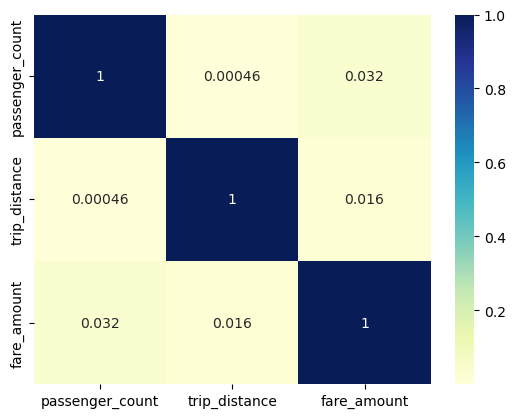

In [60]:
#Checking correlation between the variables
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='YlGnBu', annot=True)
plt.show()

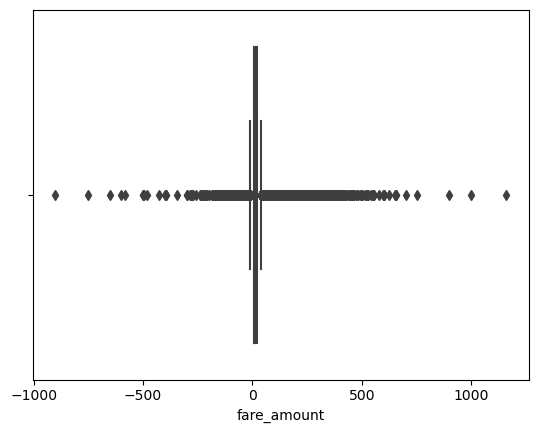

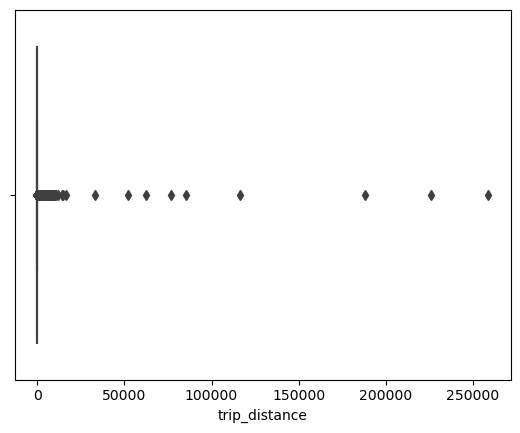

In [61]:
#Checking outliers in the fare amount and trip distance variables
sns.boxplot(x='fare_amount', data=df)
plt.show()

sns.boxplot(x='trip_distance', data=df)
plt.show()

In [62]:
#Removing outliers from the dataframe
df_new = df[(df['fare_amount'] >= 0) & (df['trip_distance'] >= 0)]
df_new.shape

(3041717, 4)

In [ ]:
sns.pairplot(df_new)

### Regression Analysis

In [63]:
#Converting time of day and day of the week to categorical variables
df_new['tpep_pickup_datetime'] = pd.to_datetime(df_new['tpep_pickup_datetime'])
df_new['hour'] = df_new['tpep_pickup_datetime'].dt.hour
df_new['day_of_week'] = df_new['tpep_pickup_datetime'].dt.dayofweek
df_new['hour'] = df_new['hour'].astype('category')
df_new['day_of_week'] = df_new['day_of_week'].astype('category')
df_new.head(20)

C:\Users\Admin\AppData\Local\Temp\ipykernel_1136\851956497.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['tpep_pickup_datetime'] = pd.to_datetime(df_new['tpep_pickup_datetime'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_1136\851956497.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['hour'] = df_new['tpep_pickup_datetime'].dt.hour
C:\Users\Admin\AppData\Local\Temp\ipykernel_1136\851956497.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,tpep_pickup_datetime,passenger_count,trip_distance,fare_amount,hour,day_of_week
0,2023-01-01 00:32:10,1.0,0.97,9.3,0,6
1,2023-01-01 00:55:08,1.0,1.10,7.9,0,6
2,2023-01-01 00:25:04,1.0,2.51,14.9,0,6
3,2023-01-01 00:03:48,0.0,1.90,12.1,0,6
4,2023-01-01 00:10:29,1.0,1.43,11.4,0,6
5,2023-01-01 00:50:34,1.0,1.84,12.8,0,6
6,2023-01-01 00:09:22,1.0,1.66,12.1,0,6
7,2023-01-01 00:27:12,1.0,11.70,45.7,0,6
8,2023-01-01 00:21:44,1.0,2.95,17.7,0,6
9,2023-01-01 00:39:42,1.0,3.01,14.9,0,6


In [64]:
#Creating dummy variables for the categorical variable
df_new = pd.get_dummies(df_new, columns=['hour', 'day_of_week'])
df_new.head()

,tpep_pickup_datetime,passenger_count,trip_distance,fare_amount,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,...,hour_21,hour_22,hour_23,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2023-01-01 00:32:10,1.0,0.97,9.3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2023-01-01 00:55:08,1.0,1.10,7.9,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2023-01-01 00:25:04,1.0,2.51,14.9,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2023-01-01 00:03:48,0.0,1.90,12.1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2023-01-01 00:10:29,1.0,1.43,11.4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [65]:
#Visualizing pairwise plot of independent and dependent variables

# Select the columns we want to include in the pairwise plots
#columns = ['fare_amount', 'trip_distance', 'passenger_count']

# Create a pairplot
#sns.pairplot(df_new[columns], diag_kind='hist', markers='+')


In [66]:
df1 = df_new.drop(['tpep_pickup_datetime'],axis = 1)
df1.dtypes

passenger_count    float64
trip_distance      float64
fare_amount        float64
hour_0               uint8
hour_1               uint8
hour_2               uint8
hour_3               uint8
hour_4               uint8
hour_5               uint8
hour_6               uint8
hour_7               uint8
hour_8               uint8
hour_9               uint8
hour_10              uint8
hour_11              uint8
hour_12              uint8
hour_13              uint8
hour_14              uint8
hour_15              uint8
hour_16              uint8
hour_17              uint8
hour_18              uint8
hour_19              uint8
hour_20              uint8
hour_21              uint8
hour_22              uint8
hour_23              uint8
day_of_week_0        uint8
day_of_week_1        uint8
day_of_week_2        uint8
day_of_week_3        uint8
day_of_week_4        uint8
day_of_week_5        uint8
day_of_week_6        uint8
dtype: object

In [67]:
#Define dependent and independent variables

X = df1.drop(['fare_amount'],axis = 1)
Y = df1['fare_amount']

In [76]:
X.dtypes

const              float64
passenger_count    float64
trip_distance      float64
hour_0               uint8
hour_1               uint8
hour_2               uint8
hour_3               uint8
hour_4               uint8
hour_5               uint8
hour_6               uint8
hour_7               uint8
hour_8               uint8
hour_9               uint8
hour_10              uint8
hour_11              uint8
hour_12              uint8
hour_13              uint8
hour_14              uint8
hour_15              uint8
hour_16              uint8
hour_17              uint8
hour_18              uint8
hour_19              uint8
hour_20              uint8
hour_21              uint8
hour_22              uint8
hour_23              uint8
day_of_week_0        uint8
day_of_week_1        uint8
day_of_week_2        uint8
day_of_week_3        uint8
day_of_week_4        uint8
day_of_week_5        uint8
day_of_week_6        uint8
dtype: object

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [70]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [71]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

Coefficients: [ 6.32981192e-01  1.08919593e-03 -4.74211033e+08 -4.74211035e+08
 -4.74211036e+08 -4.74211035e+08 -4.74211030e+08 -4.74211026e+08
 -4.74211031e+08 -4.74211034e+08 -4.74211035e+08 -4.74211035e+08
 -4.74211035e+08 -4.74211035e+08 -4.74211035e+08 -4.74211034e+08
 -4.74211033e+08 -4.74211033e+08 -4.74211033e+08 -4.74211034e+08
 -4.74211036e+08 -4.74211035e+08 -4.74211035e+08 -4.74211034e+08
 -4.74211033e+08 -4.74211032e+08  8.63796950e+07  8.63796939e+07
  8.63796934e+07  8.63796937e+07  8.63796935e+07  8.63796927e+07
  8.63796951e+07]
Intercept: 387831358.02217823


In [72]:
Y_pred = model.predict(X_test)
Y_pred

array([17.35394686, 20.09251022, 17.35280329, ..., 18.75065607,
       19.56293184, 18.93995851])

### Evaluating the model performance

In [73]:
r2_score = r2_score(Y_test, Y_pred)
print("R-squared:", r2_score)

R-squared: 0.008601770477703607


### Significance Testing

In [74]:
import statsmodels.api as sm

X = sm.add_constant(X_test) # add a constant term to the feature matrix
model = sm.OLS(Y_pred, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.117e+20
Date:                Tue, 25 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:55:17   Log-Likelihood:             1.4641e+07
No. Observations:              912516   AIC:                        -2.928e+07
Df Residuals:                  912484   BIC:                        -2.928e+07
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              15.4718    4.7e-11   3.

R-squared value = 1.000 [Model explains all of the variance in the dependent variable]
Adjusted R-squared value = 1.000[None of the independent variables added to the model were insignificant]
F-statistic = 1.117e+20 and probability value = 0.00 [Model as a whole is statistically significant]
Log-Likelihood = 1.4641e+07[Logarithm of the likelihood function for the model]

The coefficients for the independent variables show the direction and strength of the relationship between the independent variables and the dependent variable. The P>|t| values for each independent variable are all zero, indicating that all of the coefficients are statistically significant. The model seems to have been fitted to a large dataset with over 900,000 observations.

## 2. Do you think this analysis can inform policymaking? If so, in which way?

Yes, I believe this analysis definitely inform policy making by identifying factors that contribute to higher taxi fares, which could help policy makers design policies to regulate fares and improve affordability. In this analysis it's clear that the time of the day has a significant impact on fares, policymakers could consider implementing surge pricing during peak hours to reduce congestion and encourage workers to work during off-peak hours. 

### Simulating Policy Scenarios

I want to check the fare amount during peak hours, so that policy can increase the supply of taxis during peak hours. This will help the policy makers to design policies that are likely to improve affordability without significantly impacting the revenue of taxi operators in NYC.

In [78]:
# Save Model To a File Using Python Pickle
import pickle
with open('model_pickle','wb') as file:
    pickle.dump(model,file)

In [79]:
#Load saved model
with open('model_pickle','rb') as file:
    mp = pickle.load(file)

#### Peak hour fair?

###### Find fare amount on Monday at 8:00am at NYC?

In [182]:
new_data = pd.DataFrame({
    'const':[1],
    'passenger_count': [1], 
    'trip_distance': [2.5], 
    'hour_0':[0],
    'hour_1':[0],
    'hour_2':[0],
    'hour_3':[0],
    'hour_4':[0],
    'hour_5':[0],
    'hour_6':[0],
    'hour_7':[0],
    'hour_8':[1],
    'hour_9':[0],
    'hour_10':[0],
    'hour_11':[0],
    'hour_12':[0],
    'hour_13':[0],
    'hour_14':[0],
    'hour_15':[0],
    'hour_16':[0],
    'hour_17':[0],
    'hour_18':[0],
    'hour_19':[0],
    'hour_20':[0],
    'hour_21':[0],
    'hour_22':[0], 
    'hour_23':[0],
    'day_of_week_0': [1],
    'day_of_week_1':[0],
    'day_of_week_2':[0],
    'day_of_week_3':[0],
    'day_of_week_4':[0],
    'day_of_week_5':[0],
    'day_of_week_6':[0] 
})

In [184]:
# make the prediction
fare_prediction = mp.predict(new_data)
print(f"The predicted fare amount for Monday at 8:00 am is ${fare_prediction[0]:.2f}")

The predicted fare amount for Monday at 8:00 am is $18.47


#### Off-peak hour fair?

##### Find fare amount on Saturday at 5:00am at NYC?

In [189]:
new_data = pd.DataFrame({
    'const':[1],
    'passenger_count': [1], 
    'trip_distance': [2.5], 
    'hour_0':[0],
    'hour_1':[0],
    'hour_2':[0],
    'hour_3':[0],
    'hour_4':[0],
    'hour_5':[1],
    'hour_6':[0],
    'hour_7':[0],
    'hour_8':[0],
    'hour_9':[0],
    'hour_10':[0],
    'hour_11':[0],
    'hour_12':[0],
    'hour_13':[0],
    'hour_14':[0],
    'hour_15':[0],
    'hour_16':[0],
    'hour_17':[0],
    'hour_18':[0],
    'hour_19':[0],
    'hour_20':[0],
    'hour_21':[0],
    'hour_22':[0], 
    'hour_23':[0],
    'day_of_week_0': [0],
    'day_of_week_1':[0],
    'day_of_week_2':[0],
    'day_of_week_3':[0],
    'day_of_week_4':[0],
    'day_of_week_5':[1],
    'day_of_week_6':[0] 
})

In [190]:
# make the prediction
fare_prediction = mp.predict(new_data)
print(f"The predicted fare amount for Saturday at 5:00 am is ${fare_prediction[0]:.2f}")

The predicted fare amount for Saturday at 5:00 am is $25.33


## 3. What, if any, are your concerns with the data in hand? What other data could be useful for your analysis?

One concern with the data is that this is a representation of taxi trips that are paid electronically, which may not be the representative of all taxi trips in NYC. Also the data may be subjected to reporting errors or biases, such as drivers not reporting all of their trips or over reporting the fare amount. To address these concerns surveys or ride-hailing data could be used to validate the findings.

## 4. If you had more time, what would you have added to your analysis?

If I had more time, I would perform a cluster analysis to identify diffrent types of taxi trips based on their characteristics, such as distance, time of day and passenger count. This could provide insights into different market segments and help inform policy making for targeted interventions. Additionally, I would analyze external factors like weather and events on taxi fares. I also want to investigate the relationship between taxi fares and other modes of transportation like Uber/Lyft(ride-hailing) or public transit.